In [1]:
from matplotlib import pyplot as plt
import platform, os, sys, h5py
import numpy as np
from tabulate import tabulate
from pprint import pprint
from tqdm import tqdm

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append('/mnt/s/_Data/160603 - EonHe M016v5/modules')
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    %config InlineBackend.figure_format='retina'

from Common import common, kfit
from TrapAnalysis import trap_analysis, import_data, artificial_anneal as anneal
from HeliumSurface.static_surface import *
from ipywidgets import interact

%matplotlib inline

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Microwave line characterization at room temperature

In [45]:
ref_file = r"/Volumes/slab/_Data/170422 - EonHe M018V6 with L3 etch/data/170927/000_ref.csv"

ref_data = common.load_csv(ref_file)
ref_fpts = ref_data[:, 0]
ref_mags = ref_data[:, 1]

mw_input_file = r"/Volumes/slab/_Data/170422 - EonHe M018V6 with L3 etch/data/170927/001_mw_input.csv"
mw_input_data = common.load_csv(mw_input_file)
mw_input_fpts = mw_input_data[:, 0]
mw_input_mags = mw_input_data[:, 1]

The reference data contains data of two long blue cables. To find out the attenuation from the NWA to sample box we need to include the attenuation of one blue cable. Therefore, we subtract half the reference data. 

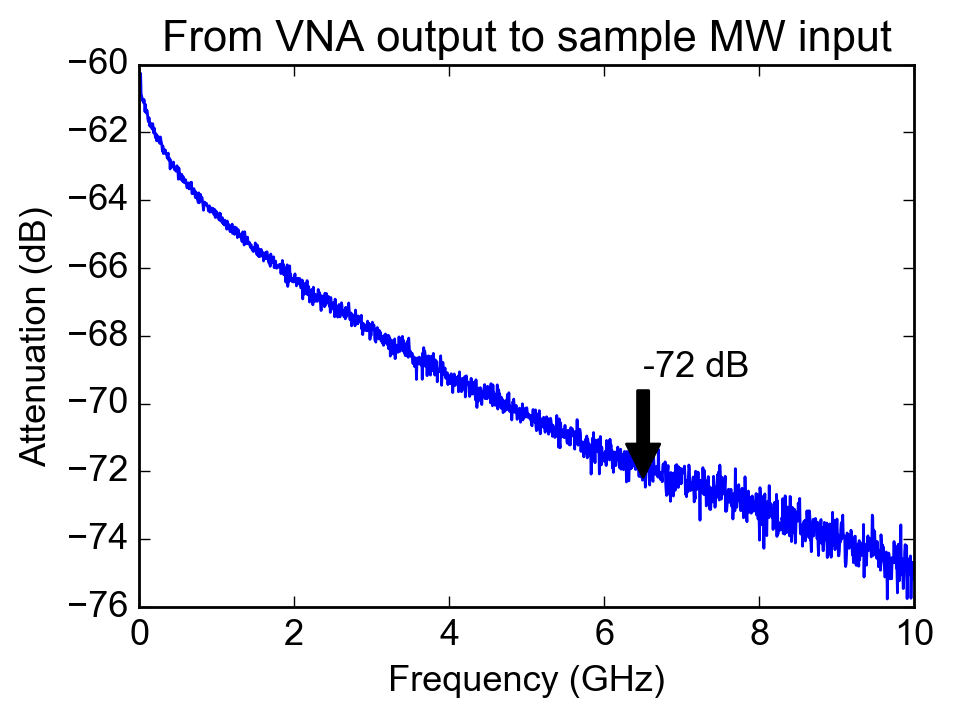

In [46]:
loss = mw_input_mags - 0.5 * ref_mags

fig = plt.figure(figsize=(5.,3.5))
common.configure_axes(13)
plt.plot(mw_input_fpts/1E9, loss)
plt.ylabel("Attenuation (dB)")
plt.xlabel("Frequency (GHz)")

fidx = common.find_nearest(mw_input_fpts, 6.5E9)
loss_at_fidx = loss[fidx]

plt.annotate('%.0f dB' % (loss_at_fidx), xy=(6.5, loss_at_fidx), xytext=(6.5, loss_at_fidx + 3),
            arrowprops=dict(facecolor='black', shrink=0.01))

plt.title("From VNA output to sample MW input")

common.save_figure(fig, save_path=r"/Volumes/slab/_Data/170422 - EonHe M018V6 with L3 etch/data/170927")

This number can be explained by 3 times -20 dB of attenuation in the line, plus ~ 10 dB attenuation in the stainless steel cable

In [47]:
mw_output_file = r"/Volumes/slab/_Data/170422 - EonHe M018V6 with L3 etch/data/170927/003_mw_output.csv"
mw_output_data = common.load_csv(mw_output_file)
mw_output_fpts = mw_output_data[:, 0]
mw_output_mags = mw_output_data[:, 1]

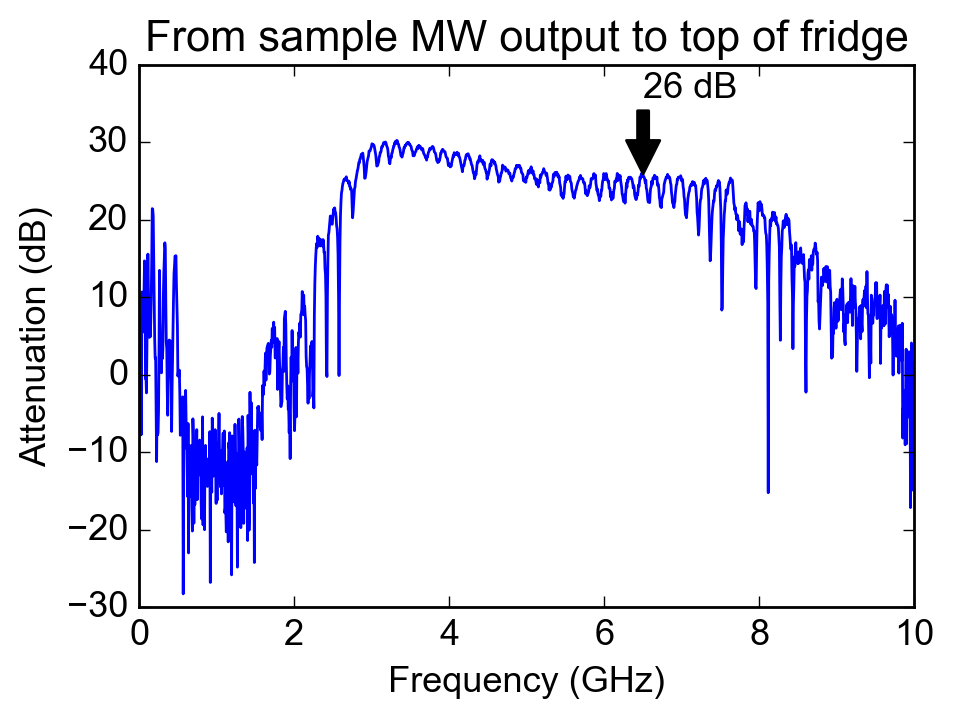

In [48]:
loss = mw_output_mags - ref_mags

fig = plt.figure(figsize=(5.,3.5))
common.configure_axes(13)
plt.plot(mw_input_fpts/1E9, loss)
plt.ylabel("Attenuation (dB)")
plt.xlabel("Frequency (GHz)")

fidx = common.find_nearest(mw_input_fpts, 6.5E9)
loss_at_fidx = loss[fidx]

plt.annotate('%.0f dB' % (loss_at_fidx), xy=(6.5, loss_at_fidx), xytext=(6.5, loss_at_fidx +10),
            arrowprops=dict(facecolor='black', shrink=0.01))

plt.title("From sample MW output to top of fridge")

common.save_figure(fig, save_path=r"/Volumes/slab/_Data/170422 - EonHe M018V6 with L3 etch/data/170927")

This number can be explained by 10 dB attenuation in the stainless steel cable, plus 40 dB gain in the LNF. In addition to that the wave passes through 3 circulators (effectively 4), which all have ~ 1dB of loss. Adding up the numbers we get +26 dB

In [49]:
mw_jpapump_file = r"/Volumes/slab/_Data/170422 - EonHe M018V6 with L3 etch/data/170927/004_jpa_pump_line_jpa_nc.csv"
mw_jpapump_data = common.load_csv(mw_jpapump_file)
mw_jpapump_fpts = mw_jpapump_data[:, 0]
mw_jpapump_mags = mw_jpapump_data[:, 1]

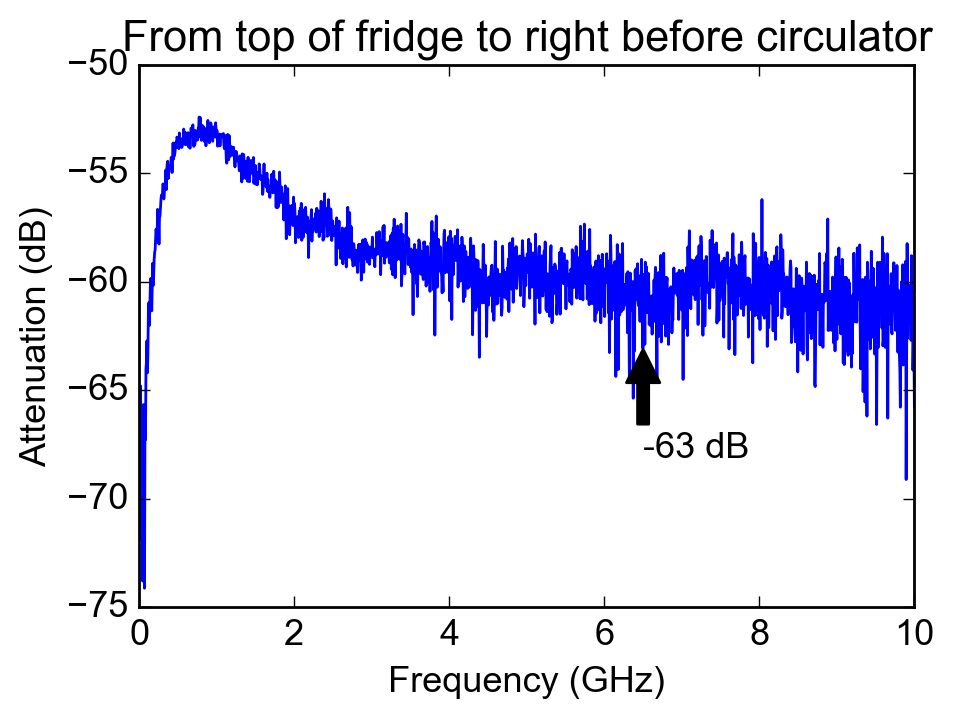

In [50]:
loss = mw_jpapump_mags - ref_mags

fig = plt.figure(figsize=(5.,3.5))
common.configure_axes(13)
plt.plot(mw_jpapump_fpts/1E9, loss)
plt.ylabel("Attenuation (dB)")
plt.xlabel("Frequency (GHz)")

fidx = common.find_nearest(mw_jpapump_fpts, 6.5E9)
loss_at_fidx = loss[fidx]

plt.annotate('%.0f dB' % (loss_at_fidx), xy=(6.5, loss_at_fidx), xytext=(6.5, loss_at_fidx -5),
            arrowprops=dict(facecolor='black', shrink=0.01))

plt.title("From top of fridge to right before circulator")

# common.save_figure(fig, save_path=r"/Volumes/slab/_Data/170422 - EonHe M018V6 with L3 etch/data/170927")

This number can be explained by -10 dB from the stainless steel lines, -20 dB at 4K, -10 dB at base and the directional coupler, which has -20 dB of attenuation

# DC filter characterization at room temperature

In [52]:
ref_file = r"/Volumes/slab/_Data/170422 - EonHe M018V6 with L3 etch/data/170927/008_REF_2LONGBLUECABLES.CSV"
ref_data = common.load_csv(ref_file)
ref_fpts = ref_data[:, 0]
ref_mags = ref_data[:, 1]

filter_file = r"/Volumes/slab/_Data/170422 - EonHe M018V6 with L3 etch/data/170927/011_ECCOSORB_AND_RC_FILTERBOARD.CSV"
filter_data = common.load_csv(filter_file)
filter_fpts = filter_data[:, 0]
filter_mags = filter_data[:, 1]

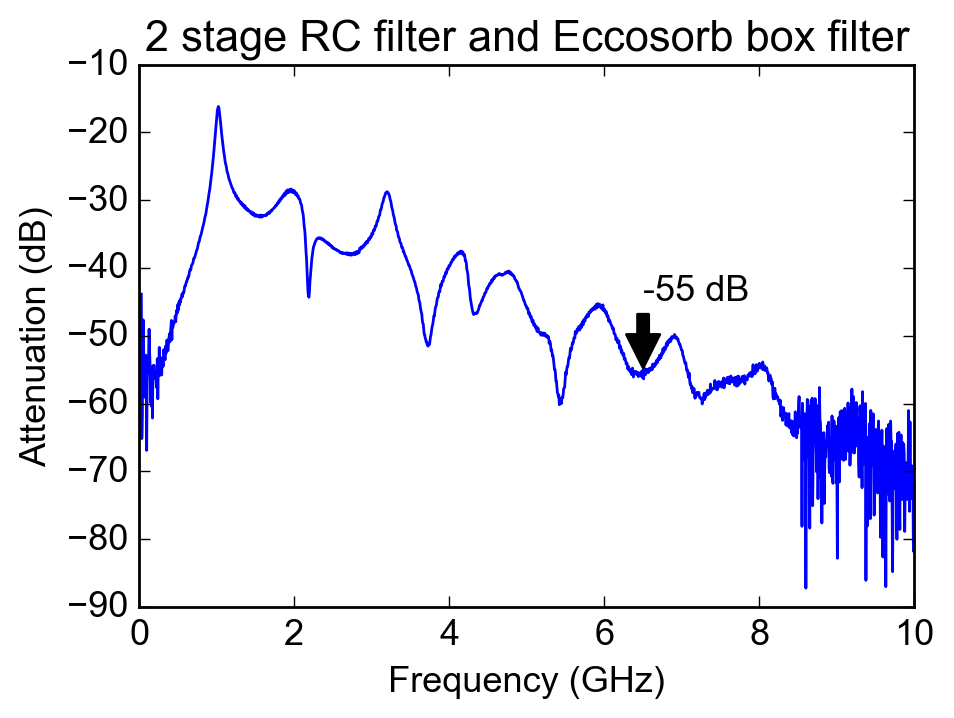

In [53]:
loss = filter_mags - ref_mags

fig = plt.figure(figsize=(5.,3.5))
common.configure_axes(13)
plt.plot(filter_fpts/1E9, loss)
plt.ylabel("Attenuation (dB)")
plt.xlabel("Frequency (GHz)")

fidx = common.find_nearest(mw_jpapump_fpts, 6.5E9)
loss_at_fidx = loss[fidx]

plt.annotate('%.0f dB' % (loss_at_fidx), xy=(6.5, loss_at_fidx), xytext=(6.5, loss_at_fidx +10),
            arrowprops=dict(facecolor='black', shrink=0.01))

plt.title("2 stage RC filter and Eccosorb box filter")

common.save_figure(fig, save_path=r"/Volumes/slab/_Data/170422 - EonHe M018V6 with L3 etch/data/170927")

Note that this graph doesn't include the on-chip filter response. Also note that even though it looks like these are open at low frequencies, the cut-off lies at ~ 1 kHz. The NWA cannot see this, but the resistance is roughly 200 $\Omega$ and capacitance ~ 3 $\cdot$ 0.44 $\mu$F